In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import scipy.linalg as linalg
import scipy.optimize as opt
import scipy.sparse as sparse
import scipy.fftpack
import matplotlib.pyplot as plt
import time
from matplotlib import pyplot as plt
import wave


def read(filename, size=-1):
    fr = wave.open(filename, "rb")
    if size == -1:
        size = fr.getnframes()
    arr = np.array(list(fr.readframes(size)))
    arr = arr.reshape((arr.shape[0] // 4, 4))
    left = arr[:, 0] + ((arr[:, 1] - 128) % 256) * 256 - 32768
    right = arr[:, 2] + ((arr[:, 3] - 128) % 256) * 256 - 32768
    return left, right

def write(filename, left, right):
    fw = wave.open(filename, "wb")
    fw.setnchannels(2)
    fw.setsampwidth(2)
    fw.setnframes(left.size)
    fw.setframerate(44100)
    for side in (left, right):
        side += 2 ** 15
        side[side < 0] = 0
        side[side > 2 ** 16 - 1] = 2 ** 16 - 1
    arr = np.array((left % 256, ((left // 256 - 128) % 256),
                   right % 256, ((right // 256 - 128) % 256)
                  )).T.flatten()
    fw.writeframes(bytes(list(arr)))
    fw.close()

In [2]:
def decompress(a, y, tol=1e-8):
    m, n = a.shape
    A_eq = np.zeros((m, 2 * n))
    A_eq[:, :n] = a

    A_ub = np.zeros((2 * n, 2 * n))
    A_ub[:n, :n] = np.identity(n)
    A_ub[:n, n:] = -np.identity(n)
    A_ub[n:, :n] = -np.identity(n)
    A_ub[n:, n:] = -np.identity(n)
    b_ub = np.zeros(2 * n)
    bounds=np.array([(None, None)] * n + [(0, None)] * n)
    c = np.zeros(2 * n)
    c[n:] = 1
    b_eq = y
    res = opt.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, 
                      #options={'maxiter': 10000, 'disp': False, 'tol': 1e-12, 'bland': False})
                      method='interior-point', options={"tol" : tol, "sym_pos" : False})
    if not res.success:
        raise Exception(res)
    return res.x[0 : n]

In [3]:
def bernoulli_matrix_gen(m, n):
    return stats.bernoulli.rvs(p=1/2, size=(m, n))

def gaussian_matrix_gen(m, n):
    return stats.norm.rvs(size=(m, n))

def mean_matrix_gen(m, n):
    a = np.zeros((m, n))
    div = n // m
    for i in range(m):
        a[i, i * div : (i + 1) * div] = 1
    a[-1, (i + 1) * div:] = 1
    return a

def chipping_gen(m, n):
    return mean_matrix_gen(m, n) @ np.diag(stats.bernoulli.rvs(p=1/2, size=n) * 2 - 1)

In [27]:
n, m = 1000, 20
A = gaussian_matrix_gen(m, n)

In [29]:
psi = np.zeros((n, n))
inv_psi = np.zeros((n, n))
e = np.identity(n)
for i in range(n):
    psi[i] = scipy.fftpack.dct(e[i], norm='ortho')
    inv_psi[i] = scipy.fftpack.idct(e[i], norm='ortho')

In [34]:
left, right = read("richard.wav")

In [40]:
arr = []
for i in range(left.size // n):
    sample = inv_psi @ left[n * i : n * (i + 1)]
    sample.sort()
    arr.append(sample[-50] / sample[-1])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


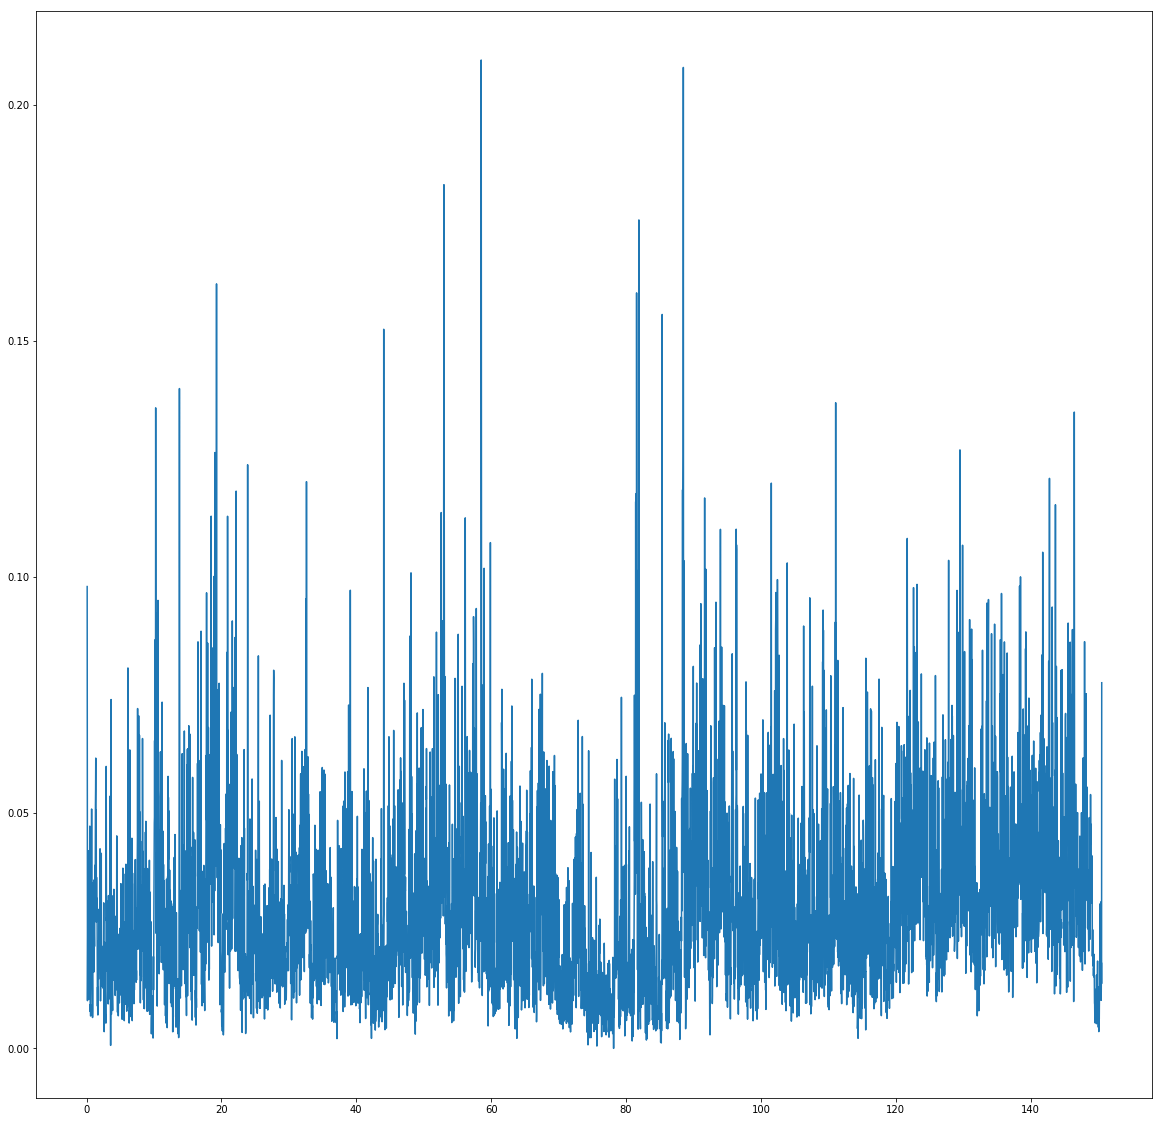

In [41]:
plt.figure(figsize=(20, 20))
plt.plot(np.arange(left.size // n) / (44100 // n), arr)

In [34]:
coef = 10
result_left, result_right = left.copy(), right.copy()
result_left[:] = 0
result_right[:] = 0
a = A @ inv_psi
last_write = 0
for i in range(left.size // n):
    print(i)
    for side in (left, right):
        frame = side[i * n : (i + 1) * n]
        try:
            decompressed_freqs = decompress(A @ inv_psi, A @ frame)
        except Exception as e:
            continue
        decompressed_frame = np.round(inv_psi @ decompressed_freqs).astype(np.int)
        print(linalg.norm(psi @ frame - decompressed_freqs))
        if side is left:
            result_left[i * n : (i + 1) * n] = decompressed_frame
        else:
            result_right[i * n : (i + 1) * n] = decompressed_frame
    if n * i // 22100 > last_write:
        write("decompressed.wav", result_left.copy(), result_right.copy())
        last_write += 1

0


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1274: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.
  OptimizeWarning)


9.867878089448544e-16
9.867878089448544e-16
1
9.867878089448544e-16
9.867878089448544e-16
2
9.867878089448544e-16
9.867878089448544e-16
3
9.867878089448544e-16
9.867878089448544e-16
4
9.867878089448544e-16
9.867878089448544e-16
5
9.867878089448544e-16
9.867878089448544e-16
6
9.867878089448544e-16
9.867878089448544e-16
7
9.867878089448544e-16
9.867878089448544e-16
8
1.1200841153580046
4.788336445182215
9
25.67278889117797


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.342506e-17
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


30.979268856054432
10
117.26851943013718
530.1966595352056
11


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.613107e-17
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


548.8668327677918


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.765639e-17
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


560.6561222415022
12
684.6251407451479
13
1986.5704893200475
910.694798865189
14
597.6141157995423
622.207539088221
15


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.512880e-18
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


616.5339887734484
518.00925657414
16
693.5710036728565


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.779204e-19
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


407.41599712434515
17


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.539325e-19
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


707.7528314009055


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.368193e-17
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


640.7147484254394
18
754.4064735600919
398.40388581135267
19
542.6237934701614


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.542623e-17
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


489.36837846976476
20
324.7954490490667
630.1093211089537
21


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.532029e-17
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


649.2172857482763
497.6590931951782
22
801.4480939059985
802.1854407604422
23


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.141337e-17
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


811.1902727160408
684.2324337244472
24
1060.9890373310047
773.5812227786168
25
701.4061063959666
718.8620154836924
26


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.023455e-17
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


1467.032157874939
1199.5395329508042
27


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.064609e-19
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


728.0814111444723
609.4565857452629
28
841.4306640700145


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.542094e-19
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


590.7624487961286
29


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.806864e-18
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


578.981977496983
498.70986670049035
30


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.220979e-19
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


739.5591810291612
322.2376690246775
31


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.495461e-17
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


1394.6269211464157


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.238048e-19
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


584.3466431043025
32
491.8500636234936
406.427998925922
33


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.283823e-19
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


668.6552958277791
824.7043088607754
34


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.749287e-17
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


840.6229336325054
1710.276512396254
35
1197.7863076763238
1808.8220302539564
36


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.312931e-18
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


1578.0970068673594
3363.434877004054
37
2242.329387279652


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.528672e-17
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


7401.546507570215
38
2600.2420997828663
39
12125.748781807484
40
4057.7559113531224
10963.254162120205
41
5790.905101658237
42
6917.677600102959
43
6581.526829559772
15066.596177406609
44
17834.83981365351
45
11756.13699843539
22598.145274012673
46
24503.52101448005
47
19070.61364259026
48
18254.239203478428
49
19529.752367689067
50
51


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_linprog_ip.py:1055: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.814068e-17
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


24894.028257259775
52
30564.655738571975
53
54
23601.628581482066
55
56
57
17153.79078283092
58
16020.297351370198
30983.31712465384
59
60
31232.297118783685
61
62
63
58737.74613760429
64
51570.07603765526
65
66
67
68
69
38875.04600358539
70
71
33495.119460235124
72
28282.560796430367
73
74
75
76
44688.04815043303
77
78
79
60763.55044662524
80
81
82
64801.971234236145
83
84
46717.72949933261
85
48422.95999128853
86
51097.84275938057
87
41817.0845797139
88
89
41622.598577544035
90
91
52240.66104862232
60565.696136592014
92
93
56252.82616596375
39930.02665342888
94
95
96
33283.991925563016
97
98
99
100
101
102
40176.526137554596
48117.60720412424
103
46953.05636016888
104
105
106
107
26697.92491098827
108
109
110
111
112
53477.36067781763
113
114
115
116
39870.83496302771
117
118
36672.6047799432
119
120
121
122
34290.82292228876
123
124
55323.765069476845
125
126
127
39132.7306427047
128
129
130
82532.35723496649
131
132
53208.43387771601
133
134
47540.53894772378
50900.81286479224
135


KeyboardInterrupt: 

In [8]:
write("decompressed.wav", result_left, result_right)

In [19]:
print(a.shape)

(100, 1000)
